# **Downloading the dataset**

In [ ]:
# !pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shinjansaha123","key":"6ce5c3ac435d54d931e1037d1d9774a0"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download manojkumarcs28/indian-sign-language-greetings-video-dataset

Dataset URL: https://www.kaggle.com/datasets/manojkumarcs28/indian-sign-language-greetings-video-dataset
License(s): CC0-1.0
  0% 0.00/60.7M [00:00<?, ?B/s]
100% 60.7M/60.7M [00:00<00:00, 1.47GB/s]


In [ ]:
!unzip indian-sign-language-greetings-video-dataset.zip

# **Data Preprocessing**

In [ ]:
!pip install mediapipe==0.10.21

In [1]:
# Import required libraries
import numpy as np
import cv2
import os
import glob
import pickle
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = "Indian Sign Language Greetings Dataset - Sub Variant of INCLUDE"
classes = os.listdir(dataset_path)
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

for class_name in classes:
    video_count = len(glob.glob(os.path.join(dataset_path, class_name, "*.mp4")))
    print(f"{class_name}: {video_count} videos")

Number of classes: 9
Classes: ['Alright', 'Good afternoon', 'Good evening', 'Good Morning', 'Good night', 'Hello', 'How are you', 'Pleased', 'Thank you']
Alright: 20 videos
Good afternoon: 20 videos
Good evening: 20 videos
Good Morning: 20 videos
Good night: 20 videos
Hello: 20 videos
How are you: 20 videos
Pleased: 20 videos
Thank you: 20 videos


Total frames: 113
Frame shape: (720, 1280, 3)


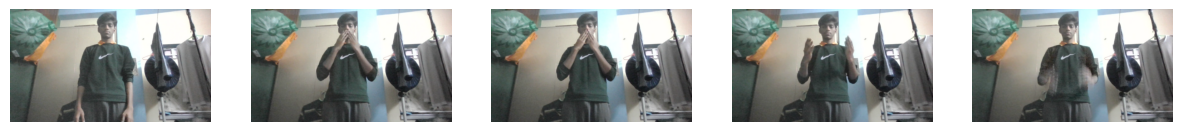

In [2]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

# Test with one video
sample_video = "Indian Sign Language Greetings Dataset - Sub Variant of INCLUDE\Thank you\WIN_20251221_21_17_00_Pro.mp4"
frames = load_video(sample_video)
print(f"Total frames: {len(frames)}")
print(f"Frame shape: {frames[0].shape}")

# Visualize some frames
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(frames[i * len(frames) // 5])
    ax.axis('off')
plt.show()

In [3]:
def visualize_sample_frames(video_path, num_frames=5):
    """Visualize evenly spaced frames from a video"""
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()

    print(f"📹 Video: {os.path.basename(video_path)}")
    print(f"   Total frames: {len(frames)}")
    print(f"   Frame shape: {frames[0].shape}")

    # Plot evenly spaced frames
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 3))
    for i, ax in enumerate(axes):
        frame_idx = i * len(frames) // num_frames
        ax.imshow(frames[frame_idx])
        ax.set_title(f'Frame {frame_idx}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return frames

# **Frame Level Augmentation**


In [4]:
# ============================================================================
# STEP 1: FRAME-LEVEL AUGMENTATION (Applied consistently per video)
# ============================================================================

class VideoFrameAugmenter:
    """Augment raw video frames consistently across all frames (frame & video level)"""

    def __init__(self):
        pass

    # ============================================================
    # FRAME-LEVEL AUGMENTATION
    # ============================================================

    def augment_frame(self, frame, aug_params):
        """Apply augmentation to a single frame"""
        augmented = frame.copy()
        h, w = augmented.shape[:2]

        # 0. Center Crop ------------------------------------------------
        crop_factor = aug_params.get("center_crop", 1.0)
        if crop_factor < 1.0:
            new_h, new_w = int(h * crop_factor), int(w * crop_factor)
            y1 = (h - new_h) // 2
            x1 = (w - new_w) // 2
            augmented = augmented[y1:y1+new_h, x1:x1+new_w]
            augmented = cv2.resize(augmented, (w, h))

        # 1. Horizontal flip -------------------------------------------
        if aug_params["flip"]:
            augmented = cv2.flip(augmented, 1)

        # 2. Rotation ---------------------------------------------------
        if aug_params["rotation"] != 0:
            M = cv2.getRotationMatrix2D((w/2, h/2), aug_params["rotation"], 1.0)
            augmented = cv2.warpAffine(augmented, M, (w, h))

        # 3. Brightness -------------------------------------------------
        if aug_params["brightness"] != 1.0:
            augmented = cv2.convertScaleAbs(
                augmented, alpha=aug_params["brightness"], beta=0
            )

        # 4. Zoom -------------------------------------------------------
        if aug_params["zoom"] != 1.0:
            zoom = aug_params["zoom"]
            new_h, new_w = int(h / zoom), int(w / zoom)
            top = (h - new_h) // 2
            left = (w - new_w) // 2
            augmented = augmented[top:top+new_h, left:left+new_w]
            augmented = cv2.resize(augmented, (w, h))

        return augmented

    # ============================================================
    # VIDEO-LEVEL TEMPORAL AUGMENTATION
    # ============================================================

    def temporal_upsample(self, frames, factor=1.5):
        """Slow motion: duplicate frames to increase frame count"""
        new_frames = []
        for f in frames:
            repeat = int(factor)
            for _ in range(repeat):
                new_frames.append(f.copy())
        return new_frames

    def temporal_downsample(self, frames, factor=1.5):
        """Fast motion: drop frames to reduce frame count"""
        step = int(factor)
        return frames[::step]

    def apply_temporal_augmentation(self, frames, temporal_type):
        """Apply temporal augmentation to entire video"""
        if temporal_type == "upsample":
            return self.temporal_upsample(frames, factor=1.5)
        elif temporal_type == "downsample":
            return self.temporal_downsample(frames, factor=1.5)
        else:  # "none"
            return frames

    # ============================================================
    # PARAMETER GENERATOR
    # ============================================================

    def generate_augmentation_params(self, num_augmentations=3):
        """Generate random augmentation parameters"""
        aug_params_list = []

        # Always include original (no augmentation)
        aug_params_list.append({
            "flip": False,
            "rotation": 0,
            "brightness": 1.0,
            "zoom": 1.0,
            "center_crop": 1.0,
            "temporal": "none"
        })

        # Generate random augmentations
        for _ in range(num_augmentations):
            aug_params_list.append({
                "flip": np.random.choice([True, False]),
                "rotation": 0,
                "brightness": np.random.uniform(0.8, 1.2),
                "zoom": 1.0,
                "center_crop": 1.0,
                "temporal": np.random.choice(["none", "upsample", "downsample"])
            })

        return aug_params_list

In [5]:
def visualize_frame_augmentations(frame, augmenter):
    """Show original frame + augmented versions"""
    aug_params_list = augmenter.generate_augmentation_params(num_augmentations=4)

    fig, axes = plt.subplots(len(aug_params_list), 1, figsize=(6, 10))
    fig.suptitle('Frame-Level Augmentations', fontsize=16, fontweight='bold')

    for i, (ax, aug_params) in enumerate(zip(axes, aug_params_list)):
        augmented = augmenter.augment_frame(frame, aug_params)
        ax.imshow(cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB))

        # Create label
        label = "Original" if i == 0 else f"Aug {i}"
        details = []
        if aug_params['flip']:
            details.append("Flip")
        if aug_params['rotation'] != 0:
            details.append(f"Rot:{aug_params['rotation']:.1f}°")
        if aug_params['brightness'] != 1.0:
            details.append(f"Bright:{aug_params['brightness']:.2f}")
        if aug_params['zoom'] != 1.0:
            details.append(f"Zoom:{aug_params['zoom']:.2f}")
        if aug_params.get('center_crop', 1.0) < 1.0:
            details.append(f"Crop:{aug_params['center_crop']:.2f}")
        if aug_params.get('temporal', 'none') != 'none':
            details.append(f"Tempo:{aug_params['temporal']}")

        title = label if i == 0 else f"{label}\n{', '.join(details)}"
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

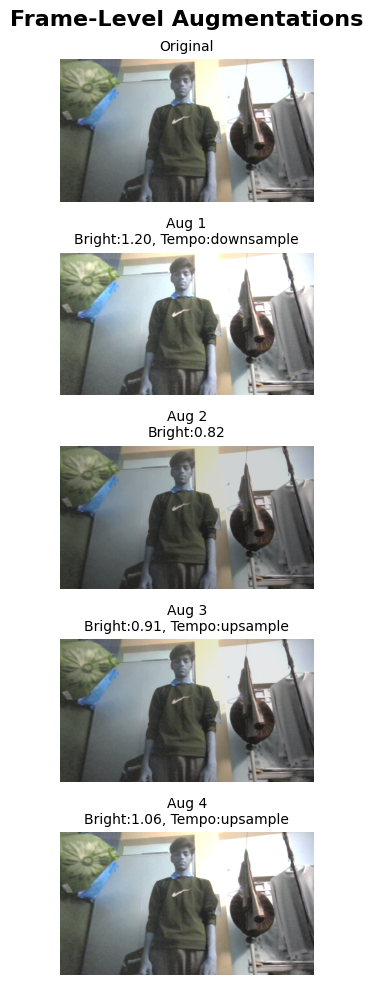

In [6]:
augmenter = VideoFrameAugmenter()
visualize_frame_augmentations(frames[int(np.random.uniform(0, len(frames)))], augmenter)

# **Mediapipe Landmark Extraction**

In [7]:
# ============================================================================
# STEP 2: MEDIAPIPE LANDMARK EXTRACTION
# ============================================================================

class MediaPipeLandmarkExtractor:
    """Extract hand, pose, and face landmarks using MediaPipe"""

    def __init__(self, include_pose=True, include_face=False):
        self.mp_holistic = mp.solutions.holistic
        self.include_pose = include_pose
        self.include_face = include_face

    def relative_normalize(self, lh, rh, pose):
      # Choose wrist as origin
      if np.any(rh):
          origin = rh.reshape(21,3)[0]
      elif np.any(lh):
          origin = lh.reshape(21,3)[0]
      else:
          origin = np.zeros(3)

      lh = lh.reshape(21,3) - origin
      rh = rh.reshape(21,3) - origin

      pose = pose.reshape(33,4)
      pose[:,:3] -= origin

      # Scale by shoulder width
      l_shoulder = pose[11][:3]
      r_shoulder = pose[12][:3]
      scale = np.linalg.norm(l_shoulder - r_shoulder) + 1e-6

      lh /= scale
      rh /= scale
      pose[:,:3] /= scale

      return np.concatenate([lh.flatten(), rh.flatten(), pose.flatten()])

    def extract_landmarks(self, frame, holistic_model):
        """Extract landmarks from a single frame"""
        # Convert BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process with MediaPipe
        results = holistic_model.process(image)

        # Extract keypoints
        landmarks = []

        # Left hand (21 landmarks x 3 coordinates = 63 values)
        if results.left_hand_landmarks:
            lh = np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]).flatten()
        else:
            lh = np.zeros(21 * 3)
        landmarks.append(lh)

        # Right hand (21 landmarks x 3 coordinates = 63 values)
        if results.right_hand_landmarks:
            rh = np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]).flatten()
        else:
            rh = np.zeros(21 * 3)
        landmarks.append(rh)

        # Pose (33 landmarks x 4 values = 132 values) - OPTIONAL
        if self.include_pose:
            if results.pose_landmarks:
                pose = np.array([[lm.x, lm.y, lm.z, lm.visibility]
                               for lm in results.pose_landmarks.landmark]).flatten()
            else:
                pose = np.zeros(33 * 4)
            landmarks.append(pose)

        # Face (468 landmarks x 3 coordinates = 1404 values) - OPTIONAL
        if self.include_face:
            if results.face_landmarks:
                face = np.array([[lm.x, lm.y, lm.z]
                               for lm in results.face_landmarks.landmark]).flatten()
            else:
                face = np.zeros(468 * 3)
            landmarks.append(face)

        return self.relative_normalize(lh, rh, pose)

    def process_video(self, video_path, max_frames=60, augment_params=None):
        """Process entire video and extract landmark sequences"""
        cap = cv2.VideoCapture(video_path)
        frames = []

        # Step 1: Load all frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        cap.release()

        if len(frames) == 0:
            # Return zero landmarks if video failed to load
            dummy_landmarks = self.extract_landmarks_dummy()
            return np.array([dummy_landmarks] * max_frames)

        # Step 2: Apply temporal augmentation (if specified)
        if augment_params is not None and "temporal" in augment_params:
            augmenter = VideoFrameAugmenter()
            frames = augmenter.apply_temporal_augmentation(frames, augment_params["temporal"])

        # Step 3: Apply frame-level augmentation and extract landmarks
        landmark_sequence = []

        with self.mp_holistic.Holistic(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        ) as holistic:

            for i, frame in enumerate(frames):
                if i >= max_frames:
                    break

                # Apply frame augmentation if params provided
                if augment_params is not None:
                    frame = VideoFrameAugmenter().augment_frame(frame, augment_params)

                # Extract landmarks
                landmarks = self.extract_landmarks(frame, holistic)
                landmark_sequence.append(landmarks)

        # Step 4: Pad sequence if shorter than max_frames
        if len(landmark_sequence) > 0:
            while len(landmark_sequence) < max_frames:
                landmark_sequence.append(np.zeros_like(landmark_sequence[0]))
        else:
            # Fallback if no landmarks extracted
            dummy_landmarks = self.extract_landmarks_dummy()
            landmark_sequence = [dummy_landmarks] * max_frames

        return np.array(landmark_sequence[:max_frames])

    def extract_landmarks_dummy(self):
        """Create dummy zero landmarks (for error cases)"""
        lh = np.zeros(21 * 3)
        rh = np.zeros(21 * 3)
        landmarks = [lh, rh]

        if self.include_pose:
            landmarks.append(np.zeros(33 * 4))
        if self.include_face:
            landmarks.append(np.zeros(468 * 3))

        return np.concatenate(landmarks)

In [8]:
def draw_mediapipe_landmarks(frame, results):
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS
        )

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS
        )

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS
        )

    return frame

In [9]:
def save_landmark_video(video_path, output_path, augment_params=None):
    cap = cv2.VideoCapture(video_path)

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = int(cap.get(cv2.CAP_PROP_FPS)) or 25

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    with mp.solutions.holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if augment_params is not None:
                frame = VideoFrameAugmenter().augment_frame(frame, augment_params)

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(rgb)

            frame = draw_mediapipe_landmarks(frame, results)
            out.write(frame)

    cap.release()
    out.release()

In [11]:
output_video = "landmarks_debug.mp4"
augmenter = VideoFrameAugmenter()
aug_params = augmenter.generate_augmentation_params()[0]

save_landmark_video(
    sample_video,
    output_video,
    augment_params=aug_params
)

# **Landmark Level Augmentation**

In [10]:
# ============================================================================
# STEP 3: LANDMARK-LEVEL AUGMENTATION
# ============================================================================

class LandmarkAugmenter:
    """Augment landmark sequences (temporal and spatial)"""

    @staticmethod
    def jitter_hands_only(sequence, noise_factor=0.015):
      seq = sequence.copy()
      hand_dim = 21 * 3 * 2  # left + right hands
      seq[:, :hand_dim] += np.random.normal(
          0, noise_factor, seq[:, :hand_dim].shape
      )
      return seq

    # def scale_landmarks(sequence, scale_range=(0.9, 1.1)):
    #     """Scale landmarks (simulate distance variation)"""
    #     scale = np.random.uniform(scale_range[0], scale_range[1])
    #     return sequence * scale

    # def rotate_landmarks_2d(sequence, angle_range=(-10, 10)):
    #     """Rotate landmarks in 2D plane (x, y coordinates)"""
    #     angle = np.radians(np.random.uniform(angle_range[0], angle_range[1]))
    #     cos_a, sin_a = np.cos(angle), np.sin(angle)

    #     # Assuming landmarks are [x, y, z, x, y, z, ...]
    #     # We'll rotate every (x, y) pair
    #     rotated = sequence.copy()
    #     num_features = sequence.shape[1]

    #     # Rotate x, y coordinates (every 3 values for 3D landmarks)
    #     for i in range(0, num_features - 2, 3):
    #         x, y = sequence[:, i], sequence[:, i + 1]
    #         rotated[:, i] = x * cos_a - y * sin_a
    #         rotated[:, i + 1] = x * sin_a + y * cos_a

    #     return rotated

    @staticmethod
    def temporal_stretch(sequence, stretch_range=(0.8, 1.2)):
        """Time warping - stretch or compress sequence temporally"""
        stretch_factor = np.random.uniform(stretch_range[0], stretch_range[1])
        original_length = len(sequence)
        new_length = int(original_length * stretch_factor)

        # Resample sequence
        indices = np.linspace(0, original_length - 1, new_length).astype(int)
        stretched = sequence[indices]

        # Pad or truncate to original length
        if len(stretched) < original_length:
            padding = np.zeros((original_length - len(stretched), sequence.shape[1]))
            stretched = np.vstack([stretched, padding])
        else:
            stretched = stretched[:original_length]

        return stretched

    @staticmethod
    def augment_sequence(sequence, num_augmentations=2):
        """Apply random augmentations to a landmark sequence"""
        augmented_sequences = [sequence]  # Include original

        for _ in range(num_augmentations):
            aug_seq = sequence.copy()

            # Randomly apply augmentations
            if np.random.rand() > 0.3:
                aug_seq = LandmarkAugmenter.jitter_hands_only(aug_seq)

            if np.random.rand() > 0.6:
                aug_seq = LandmarkAugmenter.temporal_stretch(aug_seq)
            augmented_sequences.append(aug_seq)

        return augmented_sequences

# **Dataset Processing Pipeline**

In [11]:
def plot_class_distribution(y, class_names):
    """Plot distribution of samples across classes"""
    unique, counts = np.unique(y, return_counts=True)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(unique)), counts, color='steelblue', alpha=0.8, edgecolor='black')

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
    plt.title('Class Distribution After Augmentation', fontsize=14, fontweight='bold')
    plt.xticks(range(len(unique)), class_names, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_feature_statistics(X, class_names):
    """Plot statistics of extracted features"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Feature mean across all samples
    feature_means = np.mean(X, axis=(0, 1))
    axes[0, 0].plot(feature_means, linewidth=1.5, color='steelblue')
    axes[0, 0].set_title('Mean Feature Values Across Dataset', fontweight='bold')
    axes[0, 0].set_xlabel('Feature Index')
    axes[0, 0].set_ylabel('Mean Value')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Feature variance
    feature_vars = np.var(X, axis=(0, 1))
    axes[0, 1].plot(feature_vars, linewidth=1.5, color='coral')
    axes[0, 1].set_title('Feature Variance Across Dataset', fontweight='bold')
    axes[0, 1].set_xlabel('Feature Index')
    axes[0, 1].set_ylabel('Variance')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Sequence length distribution (non-zero frames)
    seq_lengths = []
    for sample in X:
        non_zero = np.sum(np.any(sample != 0, axis=1))
        seq_lengths.append(non_zero)

    axes[1, 0].hist(seq_lengths, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Distribution of Sequence Lengths', fontweight='bold')
    axes[1, 0].set_xlabel('Number of Non-Zero Frames')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(np.mean(seq_lengths), color='red', linestyle='--',
                       label=f'Mean: {np.mean(seq_lengths):.1f}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Sample frame energy over time (average across all samples)
    frame_energy = np.mean(np.sum(np.abs(X), axis=2), axis=0)
    axes[1, 1].plot(frame_energy, linewidth=2, color='purple')
    axes[1, 1].set_title('Average Landmark Energy Over Time', fontweight='bold')
    axes[1, 1].set_xlabel('Frame Number')
    axes[1, 1].set_ylabel('Total Landmark Magnitude')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [13]:
# ============================================================================
# STEP 4: DATASET PROCESSING PIPELINE
# ============================================================================

def process_dataset(dataset_path, max_frames=60,
                   frame_aug_count=2, landmark_aug_count=2,
                   include_pose=True, include_face=False,
                   visualize_samples=False):
    """
    Complete pipeline: Frame Aug → MediaPipe → Landmark Aug

    Args:
        dataset_path: Path to dataset with structure: dataset_path/class_name/*.mp4
        max_frames: Maximum frames per video
        frame_aug_count: Number of frame-level augmentations
        landmark_aug_count: Number of landmark-level augmentations
        include_pose: Include pose landmarks
        include_face: Include face landmarks
        visualize_samples: Show visualizations during processing
    """

    X = []
    y = []

    classes = sorted([d for d in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, d))])

    print(f"Found {len(classes)} classes: {classes}")

    extractor = MediaPipeLandmarkExtractor(include_pose=include_pose, include_face=include_face)
    augmenter = VideoFrameAugmenter()

    # # VISUALIZATION 1: Show sample video frames from first class
    if visualize_samples and len(classes) > 0:
        first_class_path = os.path.join(dataset_path, classes[0])
        sample_videos = glob.glob(os.path.join(first_class_path, "*.mp4"))
        if len(sample_videos) > 0:
            print("\n" + "="*80)
            print("📊 VISUALIZATION 1: Sample Video Frames")
            print("="*80)
            sample_frames = visualize_sample_frames(sample_videos[0], num_frames=5)

            # VISUALIZATION 2: Show frame augmentations
            print("\n" + "="*80)
            print("📊 VISUALIZATION 2: Frame-Level Augmentations")
            print("="*80)
            sample_frame_bgr = cv2.cvtColor(sample_frames[len(sample_frames)//2], cv2.COLOR_RGB2BGR)
            visualize_frame_augmentations(sample_frame_bgr, augmenter)

    # Process all videos
    first_video_processed = False

    for class_idx, class_name in enumerate(tqdm(classes, desc="Processing classes")):
        class_path = os.path.join(dataset_path, class_name)
        video_files = glob.glob(os.path.join(class_path, "*.mp4"))

        print(f"\n{class_name}: {len(video_files)} videos")

        for video_idx, video_file in enumerate(tqdm(video_files, desc=f"Videos in {class_name}", leave=False)):

            # Generate frame augmentation parameters
            aug_params_list = augmenter.generate_augmentation_params(num_augmentations=frame_aug_count)

            for aug_params in aug_params_list:
                # Extract landmarks with frame augmentation
                landmark_seq = extractor.process_video(
                    video_file,
                    max_frames=max_frames,
                    augment_params=aug_params
                )

                # Apply landmark-level augmentation
                augmented_landmark_seqs = LandmarkAugmenter.augment_sequence(
                    landmark_seq,
                    num_augmentations=landmark_aug_count
                )

                for aug_landmark_seq in augmented_landmark_seqs:
                    X.append(aug_landmark_seq)
                    y.append(class_idx)

    X = np.array(X)
    y = np.array(y)

    print(f"\n✅ Dataset processed!")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Total samples: {len(X)}")
    print(f"Samples per class: {len(X) // len(classes)}")

    # VISUALIZATION 6: Class distribution
    if visualize_samples:
        print("\n" + "="*80)
        print("📊 VISUALIZATION 6: Class Distribution")
        print("="*80)
        plot_class_distribution(y, classes)

        # VISUALIZATION 7: Feature statistics
        print("\n" + "="*80)
        print("📊 VISUALIZATION 7: Feature Statistics")
        print("="*80)
        plot_feature_statistics(X, classes)

    return X, y, classes

# **Bidirectional LSTM Model**

In [14]:
# ============================================================================
# STEP 5: BUILD BIDIRECTIONAL LSTM MODEL
# ============================================================================

def build_bilstm_model(input_shape, num_classes):
    """Build Bidirectional LSTM model for sign language recognition"""

    model = Sequential([
        # Masking layer to handle variable-length sequences (padded with zeros)
        Masking(mask_value=0.0, input_shape=input_shape),

        # First BiLSTM layer
        Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_activation='hard_sigmoid', use_cudnn=False)),
        BatchNormalization(),

        # Second BiLSTM layer
        Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_activation='hard_sigmoid', use_cudnn=False)),
        BatchNormalization(),

        # Dense layers
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(128, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# **Training Pipeline**

In [17]:
# ============================================================================
# STEP 6: TRAINING PIPELINE
# ============================================================================

def train_model(X, y, class_names, epochs=100, batch_size=16):
    """Train the BiLSTM model"""

    # Train-test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Convert to one-hot encoding
    num_classes = len(class_names)
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    print(f"\n📊 Training set: {X_train.shape}")
    print(f"📊 Test set: {X_test.shape}")

    # Build model
    model = build_bilstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=num_classes
    )

    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_isl_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    class_weights = compute_class_weight(
          class_weight='balanced',
          classes=np.unique(y_train),
          y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    # Train
    print("\n🚀 Starting training...")
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    return model, history, X_test, y_test_cat

# **Model Evaluation**

In [18]:
# ============================================================================
# STEP 7: EVALUATION & VISUALIZATION
# ============================================================================

def evaluate_model(model, X_test, y_test_cat, class_names, history):
    """Evaluate model and visualize results"""

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes,
                                target_names=class_names, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Training History
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
DATASET_PATH = "Indian Sign Language Greetings Dataset - Sub Variant of INCLUDE"
MAX_FRAMES = 60
FRAME_AUG_COUNT = 1  # Number of frame-level augmentations
LANDMARK_AUG_COUNT = 0  # Number of landmark-level augmentations
INCLUDE_POSE = True  # Include pose landmarks
INCLUDE_FACE = False  # Include face landmarks (large feature space)

EPOCHS = 100
BATCH_SIZE = 16

In [23]:
# Step 1-4: Process dataset (Frame Aug → MediaPipe → Landmark Aug)
print("=" * 80)
print("STEP 1-4: PROCESSING DATASET")
print("=" * 80)

X, y, class_names = process_dataset(
        dataset_path=DATASET_PATH,
        max_frames=MAX_FRAMES,
        frame_aug_count=FRAME_AUG_COUNT,
        landmark_aug_count=LANDMARK_AUG_COUNT,
        include_pose=INCLUDE_POSE,
        include_face=INCLUDE_FACE
)

# Save processed data
with open('processed_landmarks.pkl', 'wb') as f:
    pickle.dump({'X': X, 'y': y, 'class_names': class_names}, f)
print("\n💾 Processed data saved to 'processed_landmarks.pkl'")

STEP 1-4: PROCESSING DATASET
Found 9 classes: ['Alright', 'Good Morning', 'Good afternoon', 'Good evening', 'Good night', 'Hello', 'How are you', 'Pleased', 'Thank you']


Processing classes:   0%|          | 0/9 [00:00<?, ?it/s]


Alright: 20 videos


Processing classes:  11%|█         | 1/9 [03:35<28:41, 215.17s/it]


Good Morning: 20 videos


Processing classes:  22%|██▏       | 2/9 [08:00<28:31, 244.51s/it]


Good afternoon: 20 videos


Processing classes:  33%|███▎      | 3/9 [10:44<20:47, 207.95s/it]


Good evening: 20 videos


Processing classes:  44%|████▍     | 4/9 [16:54<22:38, 271.75s/it]


Good night: 20 videos


Processing classes:  56%|█████▌    | 5/9 [20:06<16:12, 243.11s/it]


Hello: 20 videos


Processing classes:  67%|██████▋   | 6/9 [25:25<13:26, 268.73s/it]


How are you: 20 videos


Processing classes:  78%|███████▊  | 7/9 [28:35<08:06, 243.29s/it]


Pleased: 20 videos


Processing classes:  89%|████████▉ | 8/9 [31:20<03:38, 218.31s/it]


Thank you: 20 videos


Processing classes: 100%|██████████| 9/9 [34:09<00:00, 227.71s/it]


✅ Dataset processed!
X shape: (360, 60, 258)
y shape: (360,)
Total samples: 360
Samples per class: 40

💾 Processed data saved to 'processed_landmarks.pkl'


In [24]:
# Step 5-6: Train model
import pickle

with open('processed_landmarks.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']
class_names = data['class_names']

print("\n" + "=" * 80)
print("STEP 5-6: BUILDING AND TRAINING MODEL")
print("=" * 80)

model, history, X_test, y_test_cat = train_model(
        X, y, class_names,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
)


STEP 5-6: BUILDING AND TRAINING MODEL

📊 Training set: (288, 60, 258)
📊 Test set: (72, 60, 258)


c:\Users\RadhaKrishna\Downloads\Sign language transcription\isl_env\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 60, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 512)        │     1,054,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,814,025 (6.92 MB)

 Trainable params: 1,812,489 (6.91 MB)

 Non-trainable params: 1,536 (6.00 KB)


🚀 Starting training...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1660 - loss: 2.6928
Epoch 1: val_accuracy improved from None to 0.22222, saving model to best_isl_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - accuracy: 0.1458 - loss: 2.6202 - val_accuracy: 0.2222 - val_loss: 2.1417 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1948 - loss: 2.1679
Epoch 2: val_accuracy improved from 0.22222 to 0.25000, saving model to best_isl_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.2188 - loss: 2.0894 - val_accuracy: 0.2500 - val_loss: 2.0634 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.2405 - loss: 2.1031
Epoch 3: val_accuracy improved from 0.25000 to 0.31944, saving model to best_isl_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.2465 - loss: 2.0780 - val_accuracy: 0.3194 - val_loss: 1.9124 - learning_rate: 0.0010
Epoch 4/100
18/


STEP 7: EVALUATION
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 819ms/step

✅ Test Accuracy: 84.72%

📋 Classification Report:
                precision    recall  f1-score   support

       Alright      1.000     1.000     1.000         8
  Good Morning      1.000     0.625     0.769         8
Good afternoon      0.857     0.750     0.800         8
  Good evening      0.857     0.750     0.800         8
    Good night      0.500     0.875     0.636         8
         Hello      0.875     0.875     0.875         8
   How are you      1.000     1.000     1.000         8
       Pleased      0.857     0.750     0.800         8
     Thank you      1.000     1.000     1.000         8

      accuracy                          0.847        72
     macro avg      0.883     0.847     0.853        72
  weighted avg      0.883     0.847     0.853        72



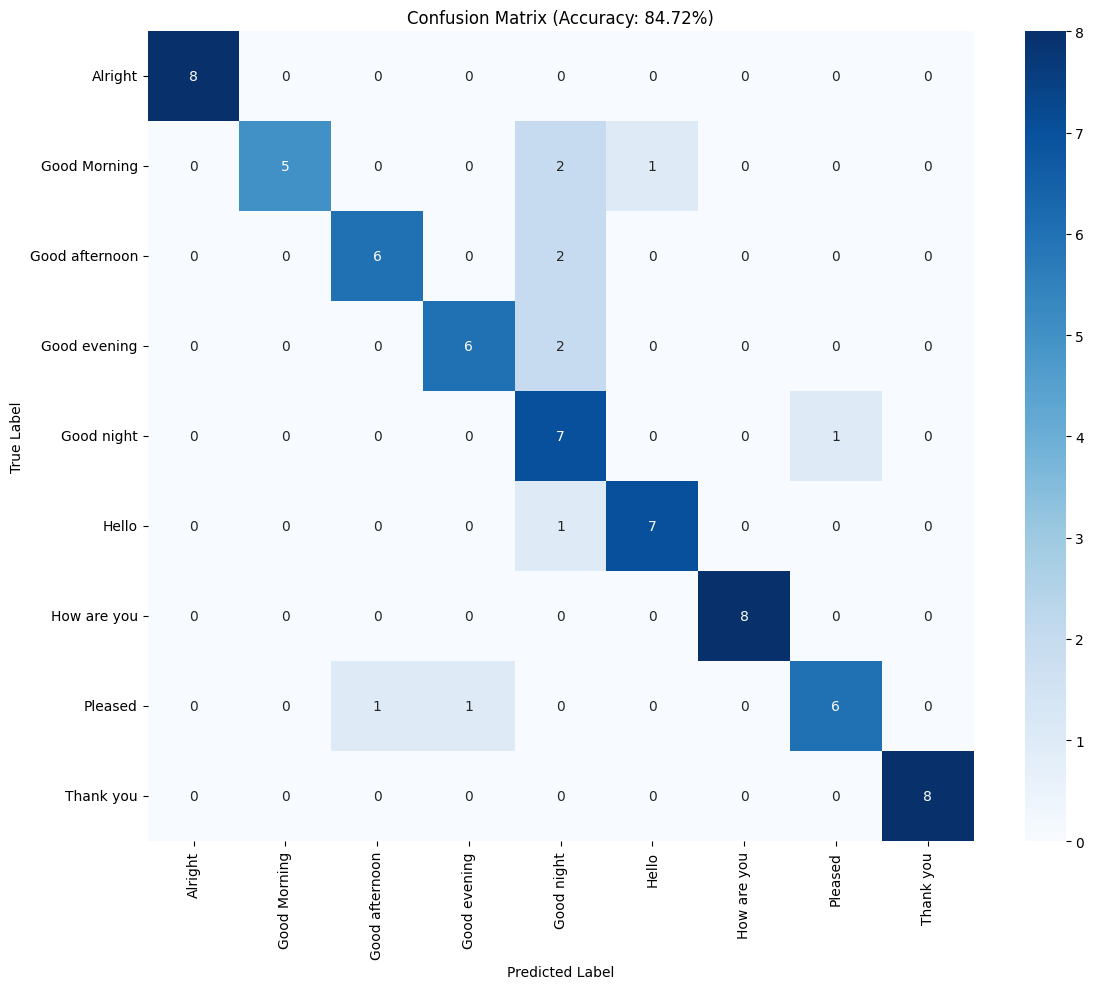

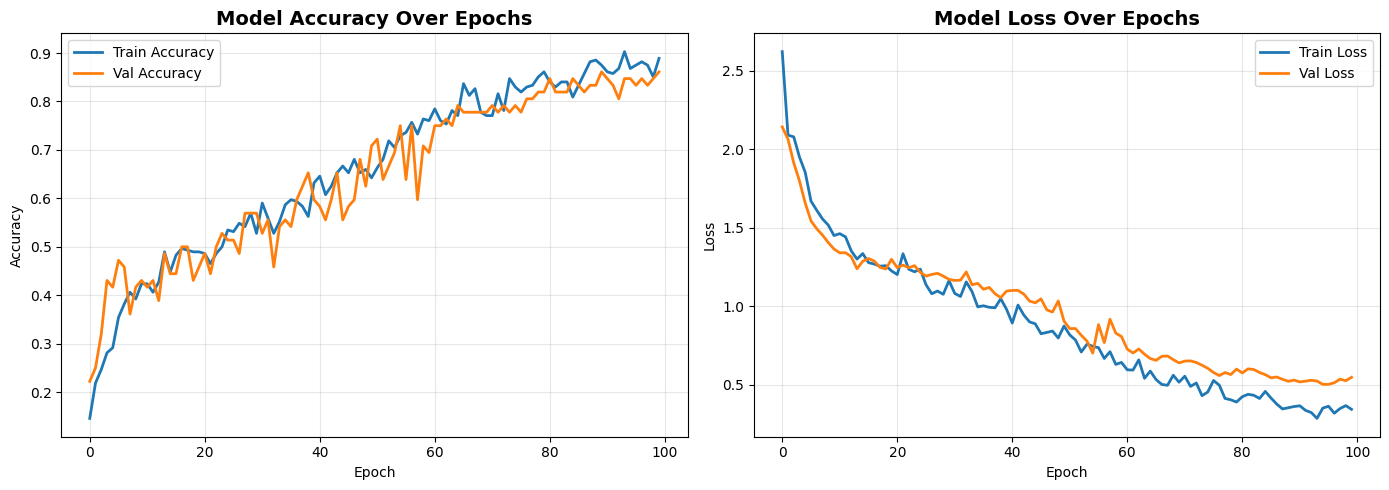


✅ Pipeline completed successfully!
📁 Outputs saved:
   - best_isl_model.keras
   - processed_landmarks.pkl
   - confusion_matrix.png
   - training_history.png


In [25]:
# Step 7: Evaluate
print("\n" + "=" * 80)
print("STEP 7: EVALUATION")
print("=" * 80)

evaluate_model(model, X_test, y_test_cat, class_names, history)

print("\n✅ Pipeline completed successfully!")
print("📁 Outputs saved:")
print("   - best_isl_model.keras")
print("   - processed_landmarks.pkl")
print("   - confusion_matrix.png")
print("   - training_history.png")

# **Model Testing**

In [15]:
# Load model
model = tf.keras.models.load_model("best_isl_model.keras")

# Load class names
with open("processed_landmarks.pkl", "rb") as f:
    data = pickle.load(f)

class_names = data["class_names"]
print("Loaded classes:", class_names)

Loaded classes: ['Alright', 'Good Morning', 'Good afternoon', 'Good evening', 'Good night', 'Hello', 'How are you', 'Pleased', 'Thank you']


In [16]:
def predict_from_video(video_path, model, class_names, max_frames=60,
                       include_pose=True, include_face=False):
    """
    Predict sign language class from a video file

    Args:
        video_path: Path to video file
        model: Trained Keras model
        class_names: List of class names
        max_frames: Maximum frames to process (must match training)
        include_pose: Must match training configuration
        include_face: Must match training configuration

    Returns:
        predicted_label: Predicted class name
        confidence: Confidence score (0-1)
        all_probs: Probability distribution over all classes
    """

    # CRITICAL: Use same configuration as training
    extractor = MediaPipeLandmarkExtractor(
        include_pose=include_pose,
        include_face=include_face
    )

    # Extract landmarks (NO augmentation for inference)
    landmark_seq = extractor.process_video(
        video_path,
        max_frames=max_frames,
        augment_params=None  # No augmentation during inference
    )

    # Check for extraction failures
    if np.all(landmark_seq == 0):
        print("⚠️ Warning: No landmarks detected in video!")
        return None, 0.0, None

    # Prepare for model (ensure correct dtype and shape)
    landmark_seq = landmark_seq.astype(np.float32)
    landmark_seq = np.expand_dims(landmark_seq, axis=0)  # (1, max_frames, num_features)

    # Predict
    probs = model.predict(landmark_seq, verbose=0)[0]
    pred_idx = np.argmax(probs)

    predicted_label = class_names[pred_idx]
    confidence = probs[pred_idx]

    # Show top 3 predictions
    top3_indices = np.argsort(probs)[-3:][::-1]
    print(f"\n🎯 Top 3 Predictions:")
    for i, idx in enumerate(top3_indices, 1):
        print(f"   {i}. {class_names[idx]}: {probs[idx]:.3f}")

    print(f"\n✅ Final Prediction: {predicted_label} (confidence: {confidence:.3f})")

    return predicted_label, confidence, probs

In [23]:
predict_from_video('Indian Sign Language Greetings Dataset - Sub Variant of INCLUDE/Good evening/MVI_005_4 (2).mp4', model, class_names)


🎯 Top 3 Predictions:
   1. Good night: 0.492
   2. Good evening: 0.485
   3. Good Morning: 0.022

✅ Final Prediction: Good night (confidence: 0.492)


('Good night',
 0.49241403,
 array([5.1211232e-06, 2.1996960e-02, 5.6041818e-04, 4.8488805e-01,
        4.9241403e-01, 1.0430674e-05, 8.7913389e-07, 1.2355084e-04,
        4.9706654e-07], dtype=float32))